# imports

In [1]:
import warnings
warnings.simplefilter('ignore')

In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
import pandas as pd
import numpy as np
import math
from torch import nn

# import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [6]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
df.emotion.value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

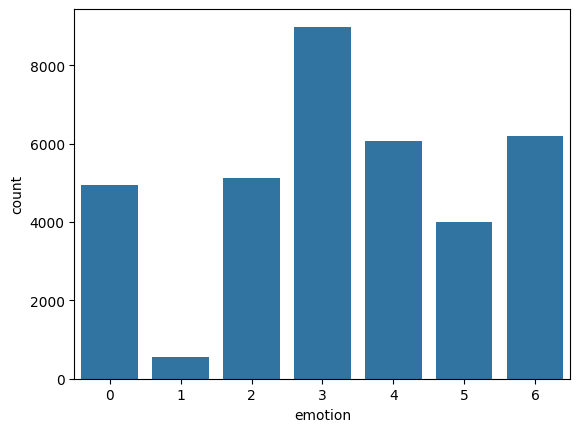

In [8]:
sns.countplot(x=df['emotion'])
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


since we have less amount of disgust (1) data we will drop the 1 part

In [10]:
df = df.drop(df[(df['emotion'] == 1) | (df['emotion'] == 2)| (df['emotion'] == 4)].index, axis=0)

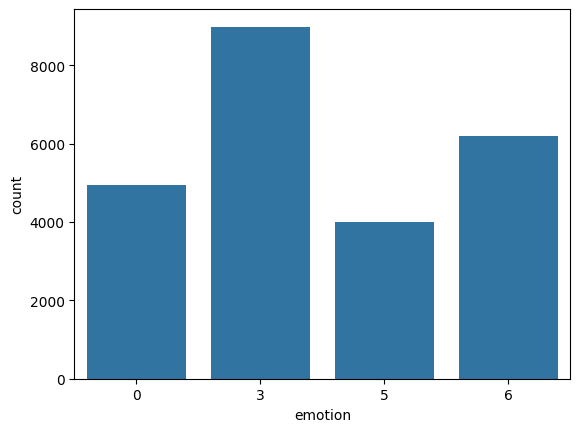

In [11]:
sns.countplot(x=df['emotion'])
plt.show()

In [12]:
math.sqrt(len(df.pixels[0].split(' ')))

48.0

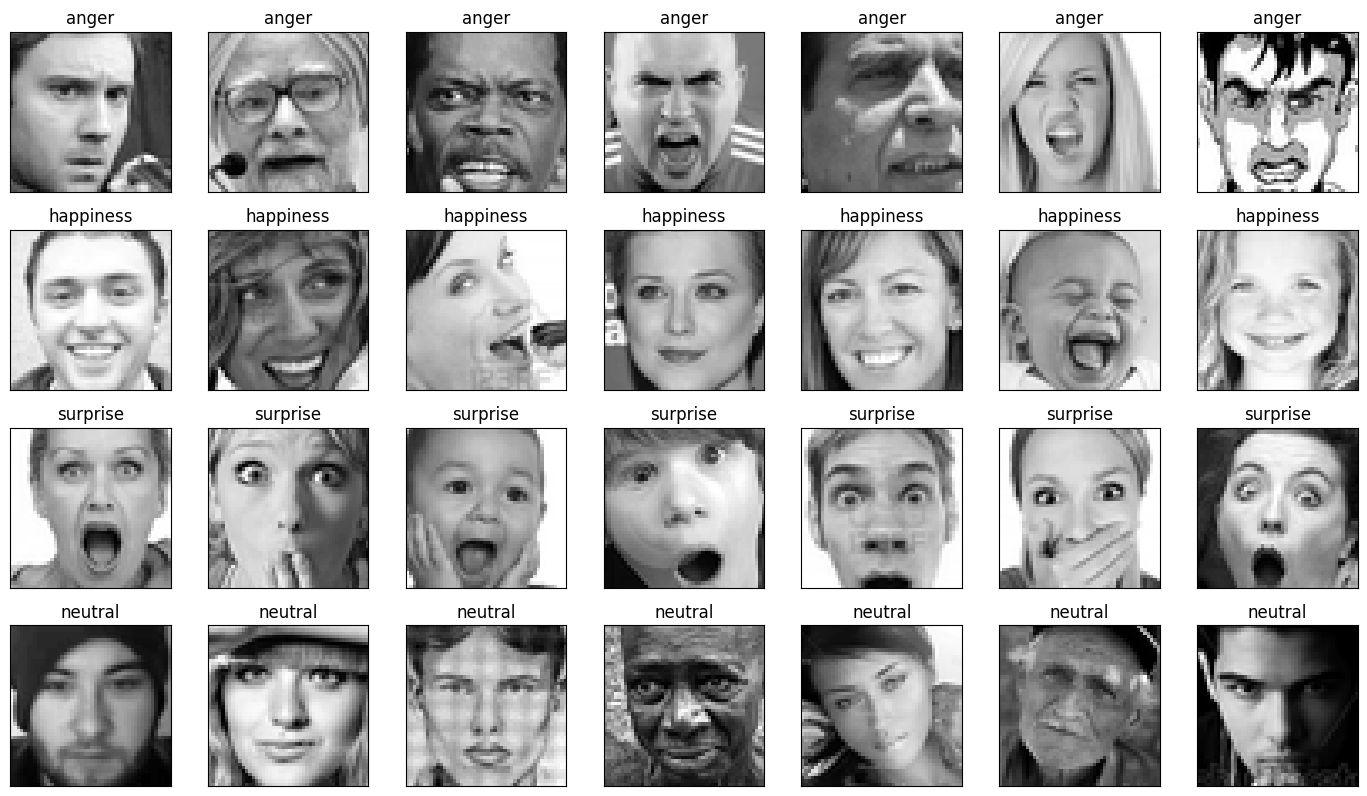

In [13]:
fig = plt.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

`Now I will make the data compatible for neural networks.`

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24142 entries, 0 to 35885
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  24142 non-null  int64 
 1   pixels   24142 non-null  object
 2   Usage    24142 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [15]:
df.emotion.nunique()

4

In [16]:
df = df.reset_index(drop=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24142 entries, 0 to 24141
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  24142 non-null  int64 
 1   pixels   24142 non-null  object
 2   Usage    24142 non-null  object
dtypes: int64(1), object(2)
memory usage: 566.0+ KB


In [18]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [19]:
def chang(emotion):
    if emotion==3:
        emotion-=2
    if emotion==5:
        emotion-=3
    if emotion==6:
        emotion-=3
    return emotion

In [20]:
df['emotion'] = df.emotion.apply(chang)

In [21]:
df.emotion.value_counts()

emotion
1    8989
3    6198
0    4953
2    4002
Name: count, dtype: int64

In [22]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,3,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
3,1,77 78 79 79 78 75 60 55 47 48 58 73 77 79 57 5...,Training
4,1,85 84 90 121 101 102 133 153 153 169 177 189 1...,Training


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'device name {device}')

device name cuda


In [24]:
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image
class custom_dataset(Dataset):
    def __init__(self,data,transform=None,target_transform=None):
        self.data = data
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return (len(self.data))
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Get pixel values and label from DataFrame
        pixel= df.iloc[idx, 1].split(' ')
        pixels = np.array(pixel).astype(np.uint8)
        label = self.data.iloc[idx, 0]
        
        # Reshape pixel values to image dimensions (assuming square images)
        image = pixels.reshape(48, 48) # Adjust dimensions as needed
        image = Image.fromarray(image)
        image = image.convert('RGB')
        # Convert to PIL image
#         image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [25]:
import torchvision.transforms as transforms

In [26]:
transform = transforms.Compose([
    # transforms.CenterCrop(48, 48),
    transforms.RandomRotation(degrees=15),           # Randomly rotate by ±15 degrees
    transforms.RandomHorizontalFlip(p=0.5),          # Randomly flip horizontally with a probability of 0.5
    transforms.RandomResizedCrop(size=(48, 48), scale=(0.8, 1.0)),  # Randomly crop and resize
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Randomly translate horizontally and vertically
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.1),  # Randomly convert to grayscale
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.1),        # Randomly apply Gaussian blur
    transforms.ToTensor(),                          # Convert to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])     # Normalize
])

In [27]:
dataset = custom_dataset(data=df, transform=transform,target_transform=None)

# dataset2 = custom_dataset(data=df, transform=transform2,target_transform=None)

# dataset = torch.utils.data.ConcatDataset([dataset1, dataset2])
# Example accessing data
image, label = dataset[2]
print("Label:", label)
print("Image shape:", image.shape)

Label: 3
Image shape: torch.Size([3, 48, 48])


In [28]:
from torch.utils.data import random_split

In [29]:
# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
print(train_size)
val_size = len(dataset) - train_size
print(val_size)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

19313
4829


In [30]:
import torch.nn as nn
import torchvision.models as models

class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        self.base_model = models.vgg19(pretrained=False)
        # Change the last fully connected layer to output num_classes
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc(x)
        return x

# Initialize model, loss function, and optimizer
model = CNNModel(num_classes=4) 
model=model.to(device)

In [31]:
model.eval()

CNNModel(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [32]:
def train_loop(dataloader,model,loss_fn,optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch,(X,y) in enumerate(dataloader):
        # Compute prediction and loss
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        #backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if batch%100 == 0:
            loss,current=loss.item(),batch*batch_size+len(X)
            print(f'train_loss:{loss:7f}  [{current:>5d}/{size:>5d}]')

In [33]:
def test_loop(dataloader,model,loss_fun):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss,correct=0,0
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X,y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss+=loss_fun(pred,y).item()
            correct+= (pred.argmax(1)==y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct/= size
    print(f'Test Error:\n Accuracy:{100*correct:0.1f}%, Avg val_loss: {test_loss:>8f}\n')
    return test_loss

In [34]:
# Load the saved model state dictionary on the appropriate device
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

CNNModel(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [35]:
loss_fun = nn.CrossEntropyLoss()
import torch.optim as optim

learning_rate = 0.0001
# beta1 = 0.9
# beta2 = 0.999
# epsilon = 1e-8

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

epochs = 100
# prev_avg_loss = float('inf')
epochs_since_last_improvement = 0
best_val_loss = float('inf')
patience = 5  # Stop training if loss doesn't decrease for 5 consecutive epochs

for t in range(epochs):
    print(f'Epoch {t+1}\n--------------')
    print(device)
    train_loop(train_loader, model, loss_fun, optimizer)
    avg_loss = test_loop(val_loader, model, loss_fun)
    print('Test Error:')
    print(f' Avg loss: {avg_loss}')
    
    if avg_loss < best_val_loss:
        # Update best validation loss
        best_val_loss = avg_loss
        epochs_without_improvement = 0
        # Save the model checkpoint
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        # Increment epochs without improvement
        epochs_without_improvement += 1
        
        # Check if early stopping criteria met
        if epochs_without_improvement >= patience:
            print(f'Validation loss did not improve for {patience} epochs. Early stopping...')
            break
print('Done')

Epoch 1
--------------
cuda
train_loss:0.277342  [  128/19313]
train_loss:0.307220  [12928/19313]
Test Error:
 Accuracy:89.0%, Avg val_loss: 0.296132

Test Error:
 Avg loss: 0.29613231906765386
Epoch 2
--------------
cuda
train_loss:0.241577  [  128/19313]
train_loss:0.222865  [12928/19313]
Test Error:
 Accuracy:89.1%, Avg val_loss: 0.289892

Test Error:
 Avg loss: 0.289891801382366
Epoch 3
--------------
cuda
train_loss:0.398541  [  128/19313]
train_loss:0.206805  [12928/19313]
Test Error:
 Accuracy:89.1%, Avg val_loss: 0.297314

Test Error:
 Avg loss: 0.29731390272316177
Epoch 4
--------------
cuda
train_loss:0.384183  [  128/19313]
train_loss:0.230220  [12928/19313]
Test Error:
 Accuracy:89.4%, Avg val_loss: 0.292624

Test Error:
 Avg loss: 0.29262364616519526
Epoch 5
--------------
cuda
train_loss:0.415295  [  128/19313]
train_loss:0.327388  [12928/19313]
Test Error:
 Accuracy:89.0%, Avg val_loss: 0.295401

Test Error:
 Avg loss: 0.29540147397078964
Epoch 6
--------------
cuda
trai

In [36]:
# Load the saved model state dictionary on the appropriate device
model.load_state_dict(torch.load('best_model.pth', map_location=device))
model.to(device)

CNNModel(
  (base_model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

In [37]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix

In [38]:
true_labels = []
predicted_labels = []
# Evaluate the model on the test set and collect true and predicted labels
model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())
# Create a dictionary for data
data = {'true_label': true_labels, 'predicted_label': predicted_labels}
# Convert the dictionary to a DataFrame
df1 = pd.DataFrame(data)

In [39]:
len(true_labels)

4829

In [40]:
len(predicted_labels)

4829

In [41]:
print(classification_report(true_labels,predicted_labels))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       985
           1       0.93      0.93      0.93      1798
           2       0.92      0.91      0.92       790
           3       0.84      0.89      0.87      1256

    accuracy                           0.89      4829
   macro avg       0.89      0.89      0.89      4829
weighted avg       0.89      0.89      0.89      4829



In [42]:
cm = confusion_matrix(true_labels, predicted_labels)
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

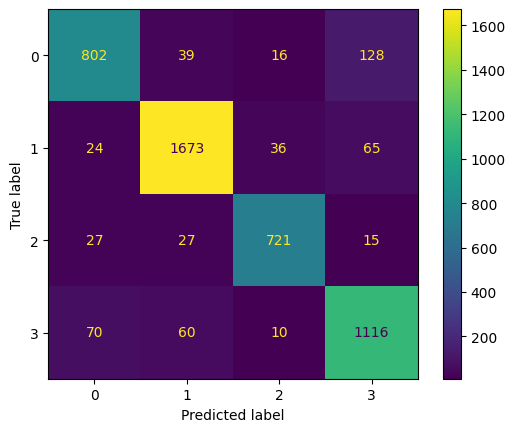

In [43]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [44]:
import torch.nn.functional as F
# Define transformations to apply to the input image
transform = transforms.Compose([
    # transforms.CenterCrop((48, 48)),
    transforms.Resize((48, 48)),  # Resize image to (48, 48)
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.ToTensor(),         # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) 
    # Add any additional transformations such as normalization here if needed
])

# Load the input image
def emotion(image_path):
    image = Image.open(image_path)
    input_image = transform(image)
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    
    # If you have a GPU, move the input image to GPU
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    input_image = input_image.to(device)
    print(input_image.shape)
    # Now 'input_image' is ready to be fed into your model for prediction
    
    # Perform inference with your model
    # Assuming your_model is your trained model
    output = model(input_image)
    
    # Assuming output is a tensor containing predicted labels, you can get the predicted label
    predicted_label_index = torch.argmax(output, dim=1).item()
    
    # Define class labels (replace with your actual class labels)
    class_labels = {0:'anger', 1:'happiness', 2: 'surprise', 3: 'neutral'}
    # Get the predicted label
    predicted_label = class_labels[predicted_label_index]
    
    # Display the image with the predicted label
    plt.imshow(image)
    plt.title(f'Predicted Label: {predicted_label}')
    plt.axis('off')  # Turn off axis
    plt.show()

torch.Size([1, 3, 48, 48])


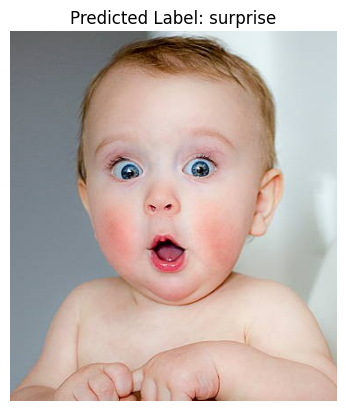

In [60]:
emotion(r"C:\Users\n\Downloads\check1.jpg")